In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Loading data

In [2]:
face,labels = fetch_olivetti_faces(return_X_y=True, shuffle=True)

In [3]:
faces = face.T
print(f'Data matrix shape: {faces.shape}')
print(f'Label matrix shape: {labels.shape}')

Data matrix shape: (4096, 400)
Label matrix shape: (400,)


## Visualizing a sample

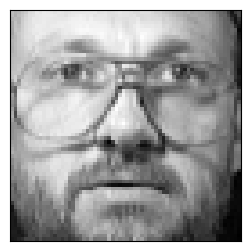

In [4]:
figure = plt.figure(figsize = (3,3))
img = faces[:,0].reshape(64,64)
plt.imshow(img,cmap = 'gray')
plt.xticks([])
plt.yticks([]);

In [5]:
## Visualizing multiple samples together

In [6]:
def visualize(index,faces,labels):
    img = faces[:,index].reshape(64,64)
    plt.imshow(img,cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Person ID: {labels[index]}')

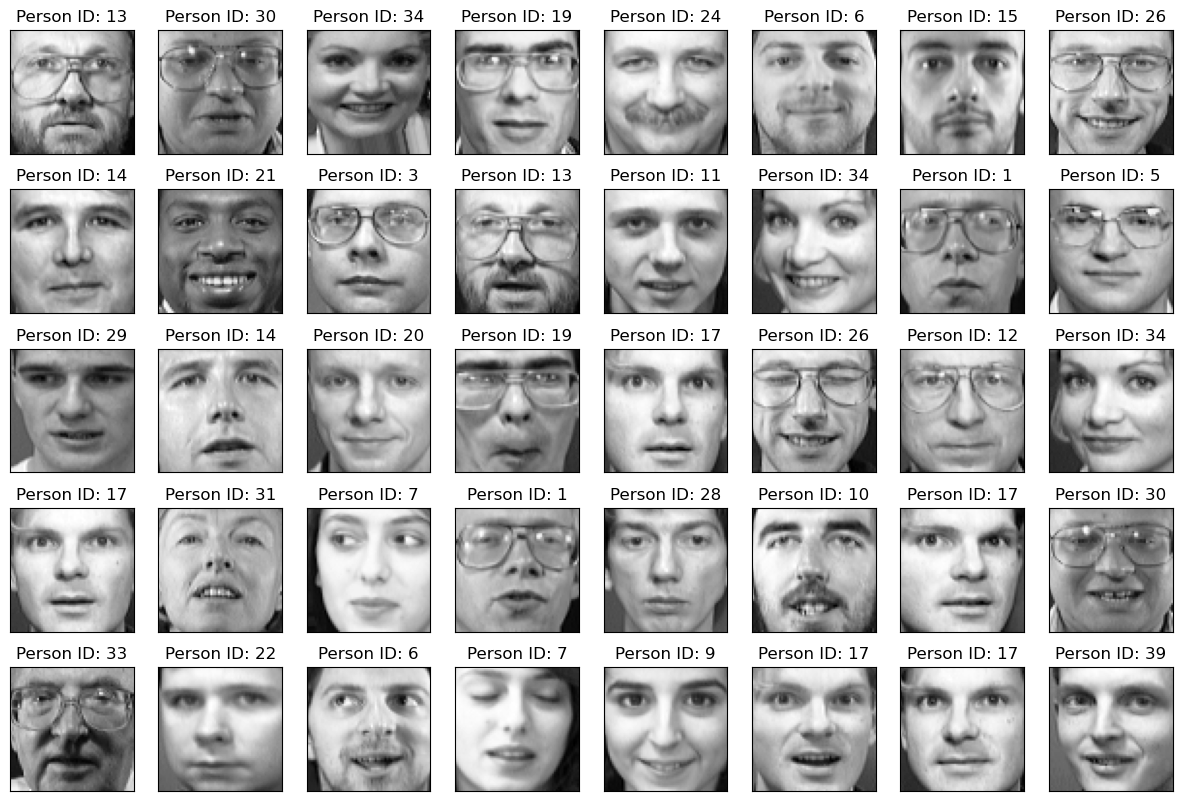

In [7]:
fig = plt.figure(figsize = (15,10))
for i in range(40):
    ax = fig.add_subplot(5,8,i+1)
    visualize(i,faces,labels)

In [8]:
print(f'Number of peopele: {len(set(labels))}')

Number of peopele: 40


## Visualizing all pictures of the same person

In [9]:
def visualize_person(index,faces,labels):
    images = faces[:,labels == index]
    fig = plt.figure(figsize = (10,4))
    for count in range(images.shape[1]):
        ax = fig.add_subplot(2,5,count+1)
        img = images[:,count].reshape(64,64)
        plt.imshow(img,cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Person ID: {index}')

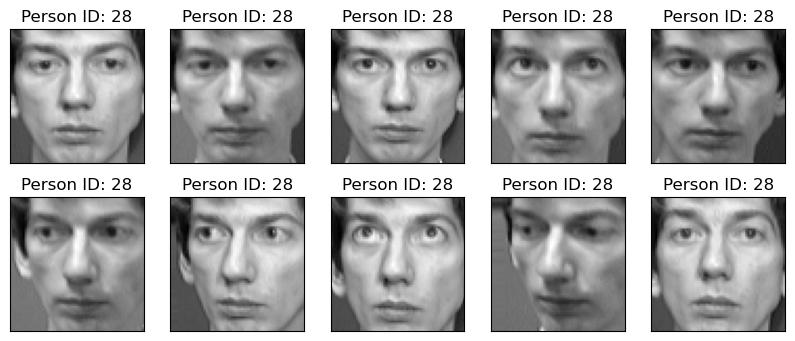

In [10]:
visualize_person(28,faces,labels)

## Idea of the project

1. Out of 400 pictures we will use a subset of 320 (80%) pictures to learn a good faces basis set.
2. We will call this set of 320 images: $\textbf{Training set}$
3. After obtaining this basis set from SVD decomposition, we will find an approximation of faces in the Training set.
4. Then we will find the coordinate of projection of images in the $\textbf{Testing set}$ (remaining set of 80 images) with respect to this basis set.
5. This coordinate set would represent an efficient encoding of the images in the testing set.
6. Using this encoding, we will create an approximation of the images in the testing set if needed.

## Dividing the data into training and testing set

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split( face, labels, test_size=0.2, random_state=42, stratify = labels)

In [13]:
print(X_train.shape, X_test.shape)

(320, 4096) (80, 4096)


In [14]:
faces_train_X = X_train.T
faces_test_X = X_test.T
faces_train_y = y_train
faces_test_y = y_test

## Visualizing the mean face in the training set

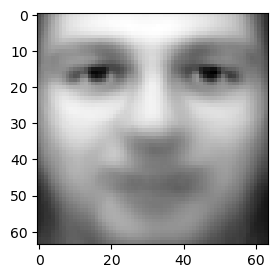

In [15]:
figure = plt.figure(figsize = (3,3))
mean_face = faces_train_X.mean(axis = 1).reshape(64,64)
plt.imshow(mean_face,cmap = 'gray');

## Centering the face matrix in the training data

In [16]:
faces_train_X_centered = faces_train_X - mean_face.reshape(-1,1)
faces_train_X_centered.shape

(4096, 320)

## Computing SVD to get an orthonormal basis set

In [17]:
U, s, V = np.linalg.svd(faces_train_X_centered,full_matrices=False)
S = np.diag(s)

In [18]:
print(U.shape,S.shape,V.shape)

(4096, 320) (320, 320) (320, 320)


## Plotting the eigenfaces: first 40 out of 320

In [19]:
def visualize_PC(index,faces,labels):
    img = faces[:,index].reshape(64,64)
    plt.imshow(img,cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'PC ID: {labels[index]}')

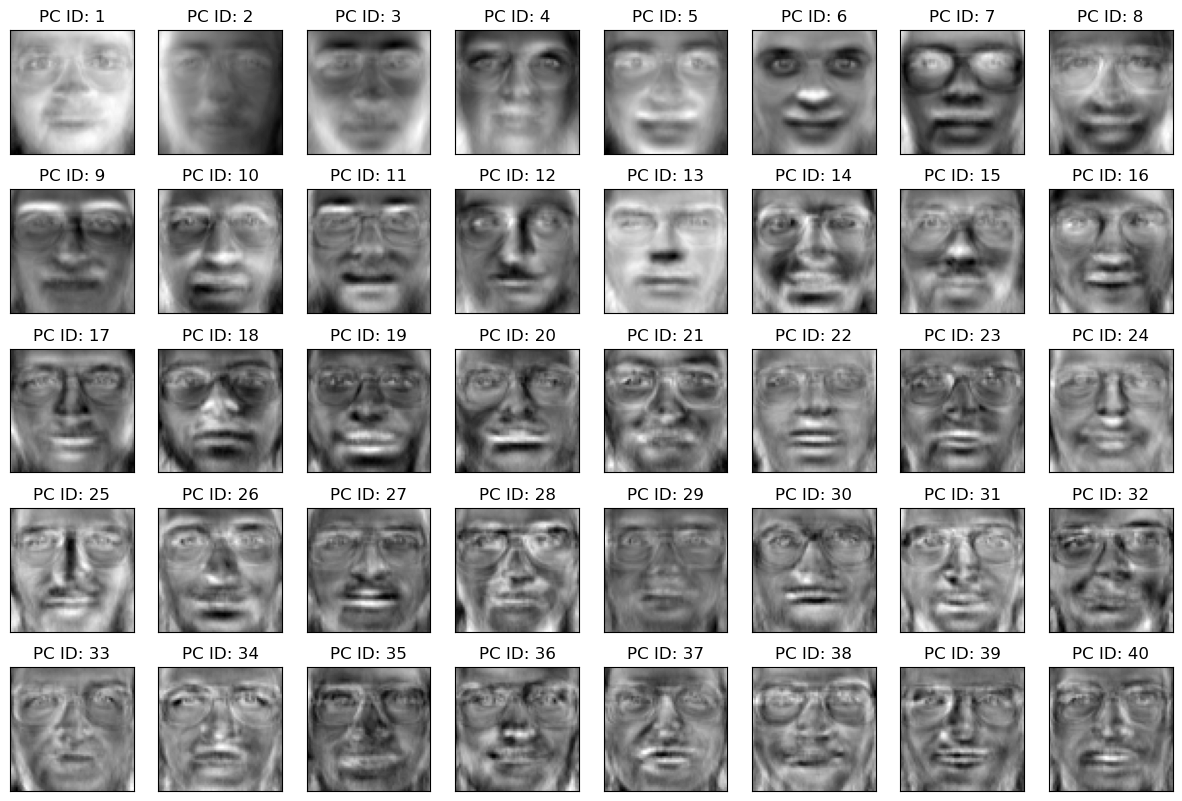

In [20]:
fig = plt.figure(figsize = (15,10))
for i in range(40):
    ax = fig.add_subplot(5,8,i+1)
    visualize_PC(i,U,np.arange(1,len(s)+1))

In the above images of Principal Components, initial components capture the main features which are common to all faces (oval face etc). Later components capture other higher resolution features like nose, glasses, ears etc. These principal components of face images are termed as $\textbf{Eigen faces}$

Hence, U contains a very good orthogonal basis for images in the set A

## Reconstructing any image in the Training set

In [24]:
def reconstruct_train(args,rank = 0):
    index,U,S,V,avg = args
    # Getting the coordinates
    wts = S@V
    relv_wts = wts[:,index]
    approx = U[:, :rank] @ relv_wts[:rank] 
    figure = plt.figure(figsize = (3,3))
    approx = approx.reshape(64,64)+ avg
    plt.imshow(approx, cmap='gray')
    plt.title(f'Rank of Approximation: {rank}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

### 1. True face from Training data

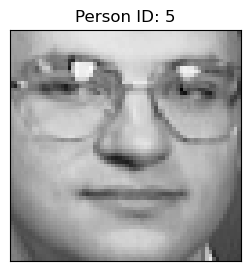

In [25]:
figure = plt.figure(figsize = (3,3))
index = 1
visualize(index,faces_train_X,faces_train_y)

### 2. Reconstructed using the learnt orthogonal basis U

In [27]:
args = [index,U,S,V,mean_face]
interact(reconstruct_train,args = fixed(args),rank = (0,len(s),1))
plt.show()

interactive(children=(IntSlider(value=0, description='rank', max=320), Output()), _dom_classes=('widget-intera…

## Reconstructing any image in the Testing set

In [32]:
def face_encoding(img,U,rank):
    encoding = U[:,:rank].T@img.reshape(-1,1)
    return encoding

def face_reconstruct(encoding,U,avg):
    len_encoding = len(encoding)
    reconstruct = U[:,:len_encoding] @ encoding
    figure = plt.figure(figsize = (3,3))
    img = reconstruct.reshape(64,64) + avg
    plt.imshow(img, cmap='gray')
    plt.title(f'Reconstruction with encoding length: {len_encoding}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

### True face from testing data

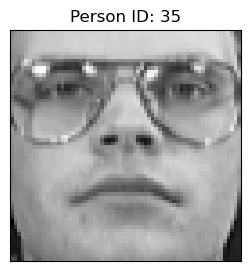

In [33]:
figure = plt.figure(figsize = (3,3))
index = 1
visualize(index,faces_test_X,faces_test_y)

### Reconstructed using the learnt orthogonal basis U

In [34]:
encoding = face_encoding(faces_test_X[:,index],U,rank = 200)
#encoding

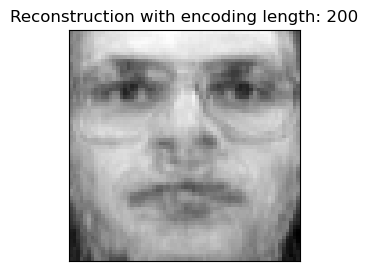

In [35]:
face_reconstruct(encoding,U,mean_face)

So if we have a universally accepted dictionary of functions U which is available to everyone. Then instead of saving any new face image in the future, we can just compute the encoding of that image (projection coordinated with respect to the orthogonal basis U) and save that. Then if that image is required later on, it can be reconstructed using the saved encoding and basis set U. This can lead to very high level of compression and hence storage savings in real life situations.